In [1]:
%pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 2.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import chi2_contingency, norm

#import statsmodels.api as sm
import statsmodels as sm
import math

from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio, equalized_odds_difference, equalized_odds_ratio

##Functions

In [3]:
def calculate_metrics(df):
    """
    Calculates the fairness metrics for a dataframe.

    Args:
        df: The dataframe.

    Returns:
        A dictionary with the fairness metrics.
    """

    def compute_metrics(group):
        tp = ((df['group'] == group) & (df['label'] == 1) & (df['pred'] == 1)).sum()
        tn = ((df['group'] == group) & (df['label'] == 0) & (df['pred'] == 0)).sum()
        fp = ((df['group'] == group) & (df['label'] == 0) & (df['pred'] == 1)).sum()
        fn = ((df['group'] == group) & (df['label'] == 1) & (df['pred'] == 0)).sum()
        total = (df['group'] == group).sum()
        sel_rate = ((df['group'] == group) & (df['pred'] == 1)).sum() / total if total > 0 else 0

        return {
            f"{group}_tp": tp,
            f"{group}_tn": tn,
            f"{group}_fp": fp,
            f"{group}_fn": fn,
            f"{group}_correct_pred": tp + tn,
            f"{group}_incorrect_pred": fp + fn,
            f"{group}_correct_pred_rate": (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0,
            f"{group}_ppv": tp / (tp + fp) if (tp + fp) > 0 else 0,
            f"{group}_sel_rate": sel_rate
        }

    women_metrics = compute_metrics("women")
    men_metrics = compute_metrics("men")

    return {**women_metrics, **men_metrics}


In [4]:
def simulate_data(n, p_label, tpr, tnr, group_name=None):
  """
  Creates a dataframe of size n with true positive rate equal to tpr and true negative rate equal to tnr.

  Args:
    n: The size of the dataframe.
    p_label_1: The proportion of the group with the outcome 1.
    tpr: The true positive rate.
    tnr: The true negative rate.

  Returns:
    A dataframe of size n with true positive rate equal to tpr and true negative rate equal to tnr.
  """

  #create the array of women's actual outcomes
  labels = np.concatenate((np.ones(round(n*p_label)), np.zeros(n - round(n*p_label))))

  #model predictions when label = 1
  preds_label_1 = np.zeros(np.count_nonzero(labels))
  preds_label_1[:round(np.count_nonzero(labels)*tpr)] = 1

  #model predictions when label = 0
  preds_label_0 = np.ones(np.count_nonzero(labels==0))
  preds_label_0[:round(np.count_nonzero(labels==0)*tnr)] = 0

  preds = np.concatenate((preds_label_1, preds_label_0))

  if group_name:
    return pd.DataFrame({'label':labels, 'pred':preds, 'group':group_name})
  else:
    return pd.DataFrame({'label':labels, 'pred':preds})




In [5]:
def simulate_population(param_dict):

  # Simulate data for women and men populations
  population = pd.concat([
      simulate_data(n=500, p_label=params["p_label"], tpr=params["tpr"], tnr=params["tnr"], group_name=group)
      for group, params in param_dict.items()
  ], axis=0)

  # Add a column for correct predictions
  population['correct_pred'] = population['pred'] == population['label']

  # Calculate and plot metrics
  pop_metrics = calculate_metrics(population)
  barplot_metrics(pop_metrics)
  pie_chart_metrics(pop_metrics)

  # Calculate additional fairness metrics
  fairness_metrics = {
      "demographic_parity_difference": demographic_parity_difference,
      "demographic_parity_ratio": demographic_parity_ratio,
      "equalized_odds_difference": equalized_odds_difference,
      "equalized_odds_ratio": equalized_odds_ratio
  }

  for metric_name, metric_func in fairness_metrics.items():
      pop_metrics[metric_name] = metric_func(population['label'], population['pred'], sensitive_features=population['group'])

  return pop_metrics, population


In [6]:
def barplot_metrics(metrics, alpha=1, save_fig=False, fname_suffix=""):
    """
    Plots a bar chart comparing metrics between men and women.

    Args:
        metrics: A dictionary containing metrics for men and women.
        alpha: Transparency level of the bars (default is 1).
        save_fig: If True, saves the figure to a file instead of displaying it (default is False).
        fname_suffix: Suffix for the saved figure filename (default is an empty string).
    """
    # Data for the chart
    categories = ['True Positives', 'False Positives', 'True Negatives', 'False Negatives']
    groups = ['men', 'women']

    data = [[metrics[f"{group}_tp"], metrics[f"{group}_fp"], metrics[f"{group}_tn"], metrics[f"{group}_fn"]] for group in groups]

    # Position of bars on the x-axis
    x = np.arange(len(categories))
    bar_width = 0.35

    # Create the bar chart
    fig, ax = plt.subplots()
    for i, group in enumerate(groups):
        ax.bar(x + i * bar_width - bar_width / 2, data[i], bar_width, label=group.capitalize(), alpha=alpha)

    # Add labels, title, and legend
    ax.set_xlabel('Categories')
    ax.set_ylabel('Counts')
    ax.set_title('Outcomes by Gender')
    ax.set_xticks(x)
    ax.set_xticklabels(categories)
    ax.legend()

    # Save or display the chart
    if save_fig:
        fname = f"barplot_outcomes_by_gender{fname_suffix}.png"
        plt.savefig(fname)
    else:
        plt.show()

    plt.close()


In [7]:
def pie_chart_metrics(metrics, alpha=1):

  labels = ['Correct', 'Incorrect']
  men = [metrics["men_correct_pred"], metrics["men_incorrect_pred"]]  # Example data for the first pie chart
  women = [metrics["women_correct_pred"], metrics["women_incorrect_pred"]]  # Example data for the second pie chart

  # Create a figure with two subplots (side by side)
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


  # Create the first pie chart
  ax1.pie(men, labels=labels, autopct='%1.1f%%', startangle=90, wedgeprops={"alpha": alpha})
  ax1.set_title('Men')

  # Create the second pie chart
  ax2.pie(women, labels=labels, autopct='%1.1f%%', startangle=90, wedgeprops={"alpha": alpha})
  ax2.set_title('Women')

  # Adjust the layout to make room for titles and labels
  plt.tight_layout()

  # Display the charts
  plt.show()

In [8]:
#Not 100% sure of this, but I think this is a test of whether the ratio is significantly different from a specified proportion
def perform_test_ratio_of_proportions(women_success, men_success, women_total, men_total, r_0=0.8):
  successes = np.array([women_success, men_success])
  nobs = np.array([women_total, men_total])

  # Calculate observed proportions
  p1 = successes[0] / nobs[0]
  p2 = successes[1] / nobs[1]

  # Calculate the observed ratio of proportions
  #Here, women_sel_rate/men_sel_rate is equivalent to demographic parity ratio
  observed_ratio = p1 / p2

  # Logarithm of the observed ratio and the threshold ratio
  log_ratio = np.log(observed_ratio)
  log_r_0 = np.log(r_0)

  # Standard error of the log ratio
  se_log_ratio = np.sqrt((1 - p1) / (nobs[0] * p1) + (1 - p2) / (nobs[1] * p2))

  # Calculate the z-statistic for the log ratio
  z_stat = (log_ratio - log_r_0) / se_log_ratio

  # Calculate the p-value (one-sided test for smaller)
  p_value = norm.cdf(z_stat)

  return z_stat, p_value

In [9]:
def simulate_audit(population, sample_size=50, samples=50, generate_figures=False, fname_suffix=""):
    sample_metrics = []
    sample_stats = []

    women_population = population[population['group'] == 'women']
    men_population = population[population['group'] == 'men']

    for sample_num in range(samples):
        # Sample women and men, then concatenate
        sample = pd.concat([
            women_population.sample(n=sample_size, random_state=sample_num),
            men_population.sample(n=sample_size, random_state=sample_num)
        ]).assign(correct_pred=lambda x: x['pred'] == x['label'])

        # Calculate metrics
        metrics = calculate_metrics(sample)
        metrics.update({
            "sample_num": sample_num,
            "demographic_parity_difference": demographic_parity_difference(sample['label'], sample['pred'], sensitive_features=sample['group']),
            "demographic_parity_ratio": demographic_parity_ratio(sample['label'], sample['pred'], sensitive_features=sample['group']),
            "equalized_odds_difference": equalized_odds_difference(sample['label'], sample['pred'], sensitive_features=sample['group']),
            "equalized_odds_ratio": equalized_odds_ratio(sample['label'], sample['pred'], sensitive_features=sample['group'])
        })

        # Define a helper function to perform chi-square tests
        def perform_chi2_test(data, group_col, test_col):
            contingency_table = pd.crosstab(data[group_col], data[test_col])
            stat, pvalue, dof, expected = chi2_contingency(contingency_table, correction=False)
            return {'chisq': stat, 'p': pvalue, 'dof': dof, 'exp': expected}

        # Perform hypothesis tests
        women_success = metrics['women_tp'] + metrics['women_fp']
        women_total = sample_size
        men_success = metrics['men_tp'] + metrics['men_fp']
        men_total = sample_size

        accuracy = perform_chi2_test(sample, 'group', 'correct_pred')
        qualified_candidates = sample[sample['label'] == 1]
        tpr = perform_chi2_test(qualified_candidates, 'group', 'correct_pred')
        sel_rate = perform_chi2_test(sample, 'group', 'pred')
        sel_rate_thresh_z, sel_rate_thresh_p = perform_test_ratio_of_proportions(women_success, men_success, women_total, men_total)

        stats = {"sample_num": sample_num, "accuracy": accuracy, "tpr": tpr, "selection_rate": sel_rate,
                 "sel_rate_thresh":{'z_stat': sel_rate_thresh_z, 'p': sel_rate_thresh_p}}

        sample_metrics.append(metrics)
        sample_stats.append(stats)

        if generate_figures:
            barplot_metrics(metrics, alpha=0.5, save_fig=True, fname_suffix=f"{fname_suffix}sample_num_{sample_num}")

    return sample_metrics, sample_stats

In [ ]:
def plot_p_values(sample_stats, metric_name='sel_rate_thresh'):

  p_vals = [sample[metric_name]['p'] for sample in sample_stats]

  print(f"Number of significant p-vals for {metric_name}: {len([p for p in p_vals if p < 0.05])}. Number of non-significant p-vals for {metric_name}: {len([p for p in p_vals if p >= 0.05])}")

  # Creating the histogram for p values for simulated samples
  plt.figure(figsize=(8, 6))
  plt.hist(p_vals, bins=20, edgecolor='black')
  # Add a vertical line at the population mean
  plt.axvline(0.05, color='red', linestyle='dashed', linewidth=2, label=f'significance: p<0.05')


  # Adding labels and title
  plt.xlabel('Values')
  plt.ylabel('Frequency')
  plt.title(f'Histogram of P Values for Hypothesis Test on {metric_name}')
  plt.legend()

  # Display the histogram
  plt.show()

##Analysis number 1: An instances with notable bias within the population

Generate a population where there is bias

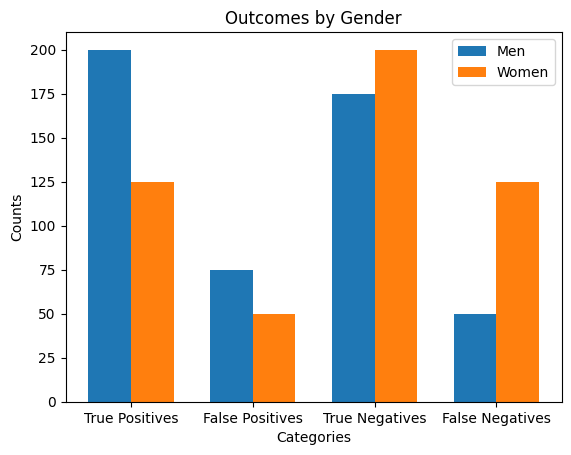

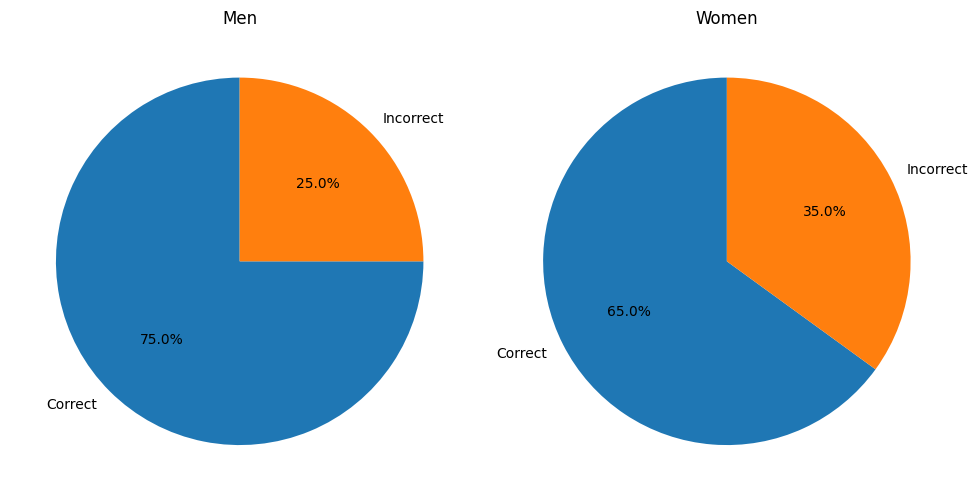

Demographic parity ratio: 0.6363636363636362
Accuracy ratio: 0.8666666666666667
PPV ratio: 0.9821428571428571


In [10]:
# Define parameters for the population
param_dict = {
    "women": {"p_label": 0.5, "tpr": 0.5, "tnr": 0.8},
    "men": {"p_label": 0.5, "tpr": 0.8, "tnr": 0.7},
}

bias_pop_metrics, bias_population = simulate_population(param_dict)
# Print summary metrics
print(f"Demographic parity ratio: {bias_pop_metrics['demographic_parity_ratio']}")
print(f"Accuracy ratio: {bias_pop_metrics['women_correct_pred'] / bias_pop_metrics['men_correct_pred']}")
print(f"PPV ratio: {bias_pop_metrics['women_ppv'] / bias_pop_metrics['men_ppv']}")


Sample repeatedly from the population and compute metrics/statistics

In [12]:
#Run the simulation
sample_metrics, sample_stats = simulate_audit(bias_population, samples=100, sample_size=50, generate_figures=True, fname_suffix="_dpr_64")

In [13]:
sample_metrics_df = pd.DataFrame(sample_metrics)
sample_metrics_df.sort_values(by='demographic_parity_ratio', ascending=False).head(5)

,women_tp,women_tn,women_fp,women_fn,women_correct_pred,women_incorrect_pred,women_correct_pred_rate,women_ppv,women_sel_rate,men_tp,...,men_correct_pred,men_incorrect_pred,men_correct_pred_rate,men_ppv,men_sel_rate,sample_num,demographic_parity_difference,demographic_parity_ratio,equalized_odds_difference,equalized_odds_ratio
22,15,20,9,6,35,15,0.70,0.625000,0.48,18,...,37,13,0.74,0.642857,0.56,22,0.08,0.857143,0.142857,0.833333
42,18,18,8,6,36,14,0.72,0.692308,0.52,22,...,39,11,0.78,0.709677,0.62,42,0.10,0.838710,0.166667,0.818182
50,15,24,5,6,39,11,0.78,0.750000,0.40,17,...,38,12,0.76,0.680000,0.50,50,0.10,0.800000,0.103448,0.625000
93,18,23,2,7,41,9,0.82,0.900000,0.40,22,...,44,6,0.88,0.880000,0.50,93,0.10,0.800000,0.160000,0.666667
96,11,23,7,9,34,16,0.68,0.611111,0.36,14,...,35,15,0.70,0.608696,0.46,96,0.10,0.782609,0.150000,0.777778


Mean demographic parity ratio across samples: 0.6335749626991874.
STD of demographic parity ratio across samples: 0.09460747566801513.
Number of instances where demographic parity is less than cutoff is 96.
Given a threshold of 0.8 for demographic parity, we would conclude correctly that the model is biased 96.0 % of the time.


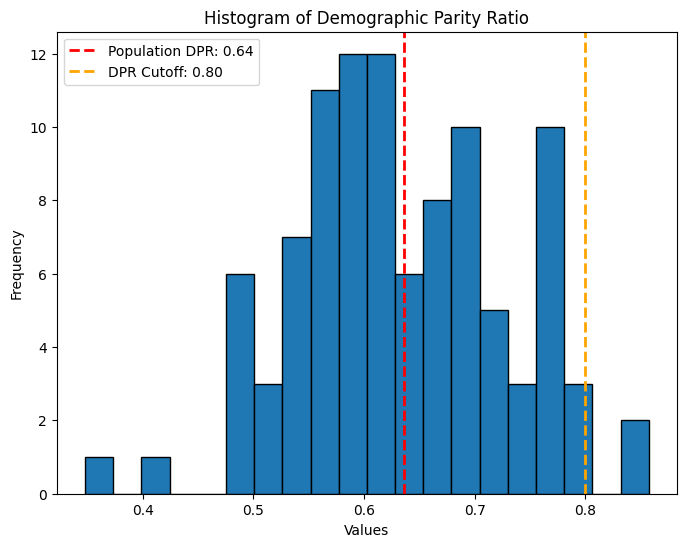

In [14]:
#calculate the demographic parity ratio for the population
pop_dpr = bias_pop_metrics['demographic_parity_ratio']
cutoff = 0.8

print(f"Mean demographic parity ratio across samples: {sample_metrics_df['demographic_parity_ratio'].mean()}.")
print(f"STD of demographic parity ratio across samples: {sample_metrics_df['demographic_parity_ratio'].std()}.")
print(f"Number of instances where demographic parity is less than cutoff is {len(sample_metrics_df[sample_metrics_df['demographic_parity_ratio'] < cutoff])}.")
print(f"Given a threshold of {cutoff} for demographic parity, we would conclude correctly that the model is biased {(len(sample_metrics_df[sample_metrics_df['demographic_parity_ratio'] < cutoff])/len(sample_metrics_df))*100} % of the time.")


# Creating the histogram for 'Column1'
plt.figure(figsize=(8, 6))
plt.hist(sample_metrics_df['demographic_parity_ratio'], bins=20, edgecolor='black')
# Add a vertical line at the population mean
plt.axvline(pop_dpr, color='red', linestyle='dashed', linewidth=2, label=f'Population DPR: {pop_dpr:.2f}')
plt.axvline(cutoff, color='orange', linestyle='dashed', linewidth=2, label=f'DPR Cutoff: {cutoff:.2f}')


# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Demographic Parity Ratio')
plt.legend()

# Display the histogram
plt.show()

In [16]:
# p_accuracy = [sample['accuracy']['p'] for sample in sample_stats]
# p_tpr = [sample['tpr']['p'] for sample in sample_stats]
# p_sel_rate = [sample['selection_rate']['p'] for sample in sample_stats]

def plot_p_values(sample_stats, metric_name='sel_rate_thresh'):

  p_vals = [sample[metric_name]['p'] for sample in sample_stats]

  print(f"Number of significant p-vals for {metric_name}: {len([p for p in p_vals if p < 0.05])}. Number of non-significant p-vals for {metric_name}: {len([p for p in p_vals if p >= 0.05])}")
  #print(f"We would conclude, incorrectly, that there is not a difference between the {metric_name} for men and women over 30% of the time.")
  #print("In other words, there are many Type II errors.")

  # Creating the histogram for p values for simulated samples
  plt.figure(figsize=(8, 6))
  plt.hist(p_vals, bins=20, edgecolor='black')
  # Add a vertical line at the population mean
  plt.axvline(0.05, color='red', linestyle='dashed', linewidth=2, label=f'significance: p<0.05')


  # Adding labels and title
  plt.xlabel('Values')
  plt.ylabel('Frequency')
  plt.title(f'Histogram of P Values for Hypothesis Test on {metric_name}')
  plt.legend()

  # Display the histogram
  plt.show()

Number of significant p-vals for sel_rate_thresh: 11. Number of non-significant p-vals for sel_rate_thresh: 89


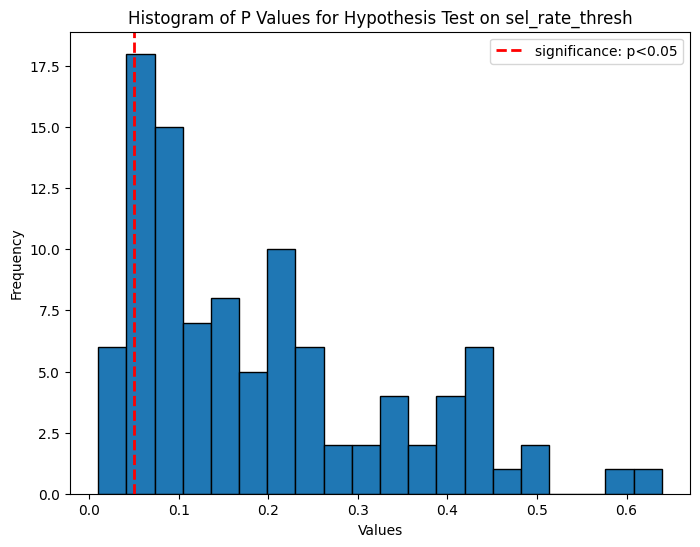

In [17]:
plot_p_values(sample_stats, metric_name='sel_rate_thresh')

In [18]:
sample_metrics_df['women_sel_rate']/sample_metrics_df['men_sel_rate']

,0
0,0.692308
1,0.583333
2,0.517241
3,0.500000
4,0.696970
...,...
95,0.703704
96,0.782609
97,0.666667
98,0.535714


##Analysis number 2: An instance where there is not significant bias in the population

Simulate a population where there is not bias

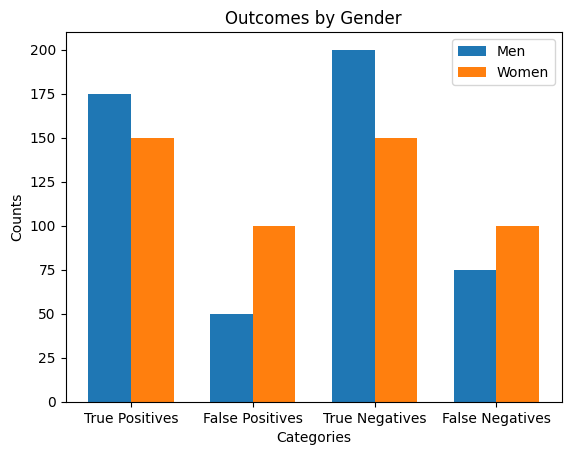

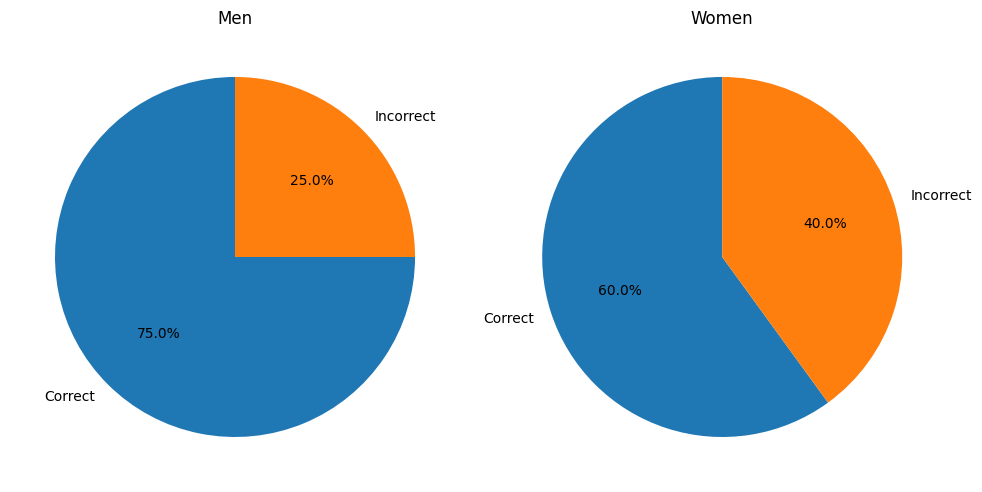

Demographic parity ratio: 0.9
Accuracy ratio: 0.8
PPV ratio: 0.7714285714285714


In [20]:
#create dataframe containing the entire sampling frame, AKA population
dpr_1 = {
    "women": {"p_label":0.5, "tpr": 0.6, "tnr":0.6},
    "men": {"p_label":0.5, "tpr": 0.7, "tnr":0.8},
    }

fair_pop_metrics, fair_population = simulate_population(dpr_1)
# Print summary metrics
print(f"Demographic parity ratio: {fair_pop_metrics['demographic_parity_ratio']}")
print(f"Accuracy ratio: {fair_pop_metrics['women_correct_pred'] / fair_pop_metrics['men_correct_pred']}")
print(f"PPV ratio: {fair_pop_metrics['women_ppv'] / fair_pop_metrics['men_ppv']}")

In [21]:
#Run the simulation
sample_metrics, sample_stats = simulate_audit(fair_population, samples=100, sample_size=50, generate_figures=True, fname_suffix="_dpr_1")

In [22]:
sample_metrics_df = pd.DataFrame(sample_metrics)
#sample_metrics_df.sort_values(by='demographic_parity_ratio', ascending=False).head(20)

,women_tp,women_tn,women_fp,women_fn,women_correct_pred,women_incorrect_pred,women_correct_pred_rate,women_ppv,women_sel_rate,men_tp,...,men_correct_pred,men_incorrect_pred,men_correct_pred_rate,men_ppv,men_sel_rate,sample_num,demographic_parity_difference,demographic_parity_ratio,equalized_odds_difference,equalized_odds_ratio
18,11,13,7,19,24,26,0.48,0.611111,0.36,14,...,30,20,0.60,0.777778,0.36,18,0.00,1.000000,0.150000,0.571429
14,17,18,8,7,35,15,0.70,0.680000,0.50,20,...,41,9,0.82,0.800000,0.50,14,0.00,1.000000,0.125000,0.625000
20,18,15,8,9,33,17,0.66,0.692308,0.52,19,...,35,15,0.70,0.730769,0.52,20,0.00,1.000000,0.043478,0.875000
44,14,15,9,12,29,21,0.58,0.608696,0.46,18,...,37,13,0.74,0.782609,0.46,44,0.00,1.000000,0.166667,0.555556
5,9,13,12,16,22,28,0.44,0.428571,0.42,14,...,32,18,0.64,0.666667,0.42,5,0.00,1.000000,0.200000,0.583333
89,16,17,6,11,33,17,0.66,0.727273,0.44,17,...,35,15,0.70,0.772727,0.44,89,0.00,1.000000,0.043478,0.833333
77,19,10,9,12,29,21,0.58,0.678571,0.56,24,...,39,11,0.78,0.857143,0.56,77,0.00,1.000000,0.263158,0.444444
85,15,17,8,10,32,18,0.64,0.652174,0.46,18,...,38,12,0.76,0.782609,0.46,85,0.00,1.000000,0.120000,0.625000
9,16,21,5,8,37,13,0.74,0.761905,0.42,18,...,41,9,0.82,0.857143,0.42,9,0.00,1.000000,0.083333,0.600000
59,18,12,9,11,30,20,0.60,0.666667,0.54,24,...,42,8,0.84,0.888889,0.54,59,0.00,1.000000,0.285714,0.333333


Mean demographic parity ratio across samples: 0.8842137355063836.
STD of demographic parity ratio across samples: 0.0829224197439443.
Number of instances where demographic parity is less than cutoff is 15.
Given a threshold of 0.8 for demographic parity, we would conclude incorrectly that the model is biased below the threshold 15.0 % of the time.


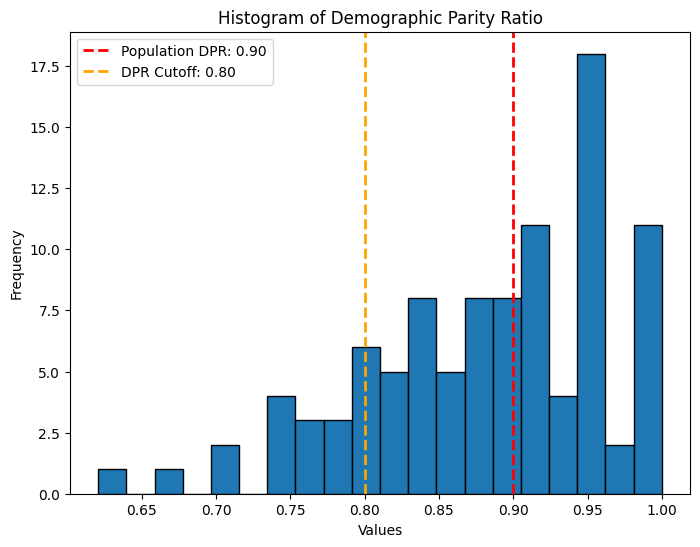

In [24]:
#calculate the demographic parity ratio for the population
pop_dpr = fair_pop_metrics['demographic_parity_ratio']
cutoff = 0.8

print(f"Mean demographic parity ratio across samples: {sample_metrics_df['demographic_parity_ratio'].mean()}.")
print(f"STD of demographic parity ratio across samples: {sample_metrics_df['demographic_parity_ratio'].std()}.")
print(f"Number of instances where demographic parity is less than cutoff is {len(sample_metrics_df[sample_metrics_df['demographic_parity_ratio'] < cutoff])}.")
print(f"Given a threshold of {cutoff} for demographic parity, we would conclude incorrectly that the model is biased below the threshold {(len(sample_metrics_df[sample_metrics_df['demographic_parity_ratio'] < cutoff])/len(sample_metrics_df))*100} % of the time.")


# Creating the histogram for 'Column1'
plt.figure(figsize=(8, 6))
plt.hist(sample_metrics_df['demographic_parity_ratio'], bins=20, edgecolor='black')
# Add a vertical line at the population mean
plt.axvline(pop_dpr, color='red', linestyle='dashed', linewidth=2, label=f'Population DPR: {pop_dpr:.2f}')
plt.axvline(cutoff, color='orange', linestyle='dashed', linewidth=2, label=f'DPR Cutoff: {cutoff:.2f}')


# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Demographic Parity Ratio')
plt.legend()

# Display the histogram
plt.show()

In [19]:
#https://www.jonathanbossio.com/post/two-sample-chi-square-test-with-python
#https://stats.oarc.ucla.edu/other/gpower/two-independent-proportions-power-analysis/


In [22]:
p_sel_rate_thresh = [sample['sel_rate_thresh']['p'] for sample in sample_stats]

len([p for p in p_sel_rate_thresh if p < 0.05])/len(p_sel_rate_thresh)

0.11

In [20]:
#import statsmodels.api as sm

# Example data
# Group 1: 40 successes out of 100 trials
# Group 2: 30 successes out of 90 trials

successes = np.array([women_success, men_success])
nobs = np.array([women_total, men_total])

# The threshold difference you want to test against (delta_0)
delta_0 = 0.8

# Calculate the z-test for the difference in proportions
z_stat, p_value = sm.stats.proportions_ztest(successes, nobs, value=delta_0, alternative='smaller')

print(f"Z-statistic: {z_stat}")
print(f"P-value: {p_value}")

# Interpretation
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis: The difference in rates is significantly smaller than the threshold.")
else:
    print("Fail to reject the null hypothesis: The difference in rates is not significantly smaller than the threshold.")


Z-statistic: -9.669875568304564
P-value: 2.0243502162288462e-22
Reject the null hypothesis: The difference in rates is significantly greater than the threshold.


In [16]:
#Not 100% sure of this, but I think this is a test of whether the ratio is significantly different from a specified proportion

def test_ratio_of_proportions(women_success, men_success, women_total, men_total, r_0=0.8):
  successes = np.array([women_success, men_success])
  nobs = np.array([women_total, men_total])

  # Calculate observed proportions
  p1 = successes[0] / nobs[0]
  p2 = successes[1] / nobs[1]

  # Calculate the observed ratio of proportions
  observed_ratio = p1 / p2

  # # The threshold ratio you want to test against (r_0)
  # r_0 = 0.8

  # Logarithm of the observed ratio and the threshold ratio
  log_ratio = np.log(observed_ratio)
  log_r_0 = np.log(r_0)

  # Standard error of the log ratio
  se_log_ratio = np.sqrt((1 - p1) / (nobs[0] * p1) + (1 - p2) / (nobs[1] * p2))

  # Calculate the z-statistic for the log ratio
  z_stat = (log_ratio - log_r_0) / se_log_ratio

  # Calculate the p-value (one-sided test for smaller)
  p_value = norm.cdf(z_stat)

  return z_stat, p_value

  # print(f"Z-statistic: {z_stat}")
  # print(f"P-value: {p_value}")

  # # Interpretation
  # alpha = 0.05  # Significance level
  # if p_value < alpha:
  #     print("Reject the null hypothesis: The ratio of proportions is significantly smaller than the threshold.")
  # else:
  #     print("Fail to reject the null hypothesis: The ratio of proportions is not significantly smaller than the threshold.")


Z-statistic: -0.6220800921929969
P-value: 0.2669446023210791
Fail to reject the null hypothesis: The ratio of proportions is not significantly smaller than the threshold.


In [18]:
sample_stats


[{'sample_num': 0,
  'accuracy': {'chisq': 0.18382352941176472,
   'p': 0.6681077437666942,
   'dof': 1,
   'exp': array([[16., 34.],
          [16., 34.]])},
  'tpr': {'chisq': 2.1222410865874366,
   'p': 0.14517397969585702,
   'dof': 1,
   'exp': array([[ 9.5, 15.5],
          [ 9.5, 15.5]])},
  'selection_rate': {'chisq': 2.5974025974025974,
   'p': 0.1070390103470981,
   'dof': 1,
   'exp': array([[28., 22.],
          [28., 22.]])},
  'sel_rate_thresh': {'z_stat': -0.6220800921929969, 'p': 0.2669446023210791}},
 {'sample_num': 1,
  'accuracy': {'chisq': 0.8316008316008316,
   'p': 0.3618100399768197,
   'dof': 1,
   'exp': array([[13., 37.],
          [13., 37.]])},
  'tpr': {'chisq': 5.0814814814814815,
   'p': 0.02418269837772487,
   'dof': 1,
   'exp': array([[ 7.5, 13.5],
          [ 7.5, 13.5]])},
  'selection_rate': {'chisq': 4.244482173174873,
   'p': 0.03937807673441802,
   'dof': 1,
   'exp': array([[31., 19.],
          [31., 19.]])},
  'sel_rate_thresh': {'z_stat': -1.